# Getting Data:

The data used in this project is from a dataset in this url : <a>https://www.kaggle.com/datasets/wenruliu/adult-income-dataset</a>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Read data from file as a dataframe

In [2]:
#Read data 
data = pd.read_csv('./data/adult.csv')


# Data cleaning for model training


### Remove unwanted columns
we will not use all column because not all of them looks relevent to our subject 

In [3]:
data = data.drop(
    ['fnlwgt', 'educational-num',
       'relationship', 'race','native-country'
       ]
    ,axis=1)

### Remove rows which has empty value. it marked by '?'

In [ ]:
data = data[~data.isin(['?']).any(axis=1)]
data.count()

# EDA
### Understanding data
All columns exist in our data

In [ ]:
data.columns

### Extract all features in data
Showing all non numerical feautures of data

In [ ]:
# Showing all non numerical values of data
not_null_data = data[~data.isin(['?']).any(axis=1)] # Datarows which has ? are removed
data_elements = {col : not_null_data[col].unique() for col in ['education','workclass','marital-status','occupation','gender']} # non numerical columns
data_feat = pd.DataFrame(dict([(c, pd.Series(v)) for c, v in data_elements.items()]))
data_feat

### Age and income (Histogram)


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Bigger than 50K
big_sal = data[data['income']=='>50K']
big_sal['age'].plot(kind='hist',ax=axes[0][0],label='Age histogram',bins=20,
                      title='Age of employees which their salary bigger than 50K',
                      color='red', edgecolor='black')

axes[0][0].set_xlabel('age')
axes[0][0].set_ylabel('count')
axes[0][0].legend()
for container in axes[0][0].containers:
    axes[0][0].bar_label(container, label_type='edge')
axes[0][0].plot()

big_sal['age'].plot(kind='kde',ax=axes[1][0],label='Age KDE',
                      color='red')
axes[1][0].set_xlabel('Age')
axes[1][0].set_ylabel('density')
axes[1][0].plot()

# lesser than 50K
small_sal = not_null_data[not_null_data['income']=='<=50K']
small_sal['age'].plot(kind='hist', ax=axes[0][1],label='Age histogram',bins=10,
                      title='Age of employees which their salary smaller than 50K',
                      color='blue')
axes[0][1].set_xlabel('Age')
axes[0][1].set_ylabel('Count')
axes[0][1].legend()
for container in axes[0][1].containers:
    axes[0][1].bar_label(container, label_type='edge')
axes[0][1].plot()

small_sal['age'].plot(kind='kde',ax=axes[1][1],label='Age KDE',
                      color='blue')
axes[1][1].set_xlabel('Age')
axes[1][1].set_ylabel('density')
axes[1][1].plot()


plt.tight_layout()
plt.show()

## Education per Income (Bar)
  

In [ ]:
# Education levels its ordered based on level of education
educations = ['Preschool', '1st-4th','5th-6th',
              '7th-8th', '9th', '10th',
              '11th', '12th', 'HS-grad',
              'Assoc-voc', 'Some-college', 'Assoc-acdm',
               'Prof-school', 'Bachelors', 'Masters','Doctorate',
                ]
# Group by occupation and salary and count occurrences
Education_counts = data.groupby(['education', 'income']).size().unstack(fill_value=0)

# Plot the bar chart
Education_counts['total'] = Education_counts.sum(axis=1)
Education_counts_sorted = Education_counts.loc[educations].drop(columns='total')


ax = Education_counts_sorted.plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'orange'])
# Add labels and title
plt.title('number of peoples Salaries based on jobs title')
plt.xlabel('Occupation')
plt.ylabel('Number')
plt.xticks(ha='right')
plt.legend(title='Salary')

for container in ax.containers:
    ax.bar_label(container, label_type='edge')
# Show the plot
plt.tight_layout()
plt.show()

## Work class and income (Pie)

In [ ]:
# Group by work class and salary and count occurrences

big_sal = data[data['income'] == '>50K']
big_sal = big_sal[big_sal['workclass'] != '?']

sml_sal = data[data['income'] == '<=50K']
sml_sal = sml_sal[sml_sal['workclass'] != '?']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

big_sal['workclass'].value_counts().plot(kind='pie',ax=axes[0],title='Number of People Earning more than $50K by Work Classes', autopct='%1.1f%%')
axes[0].legend(loc='best')
axes[0].plot()

sml_sal['workclass'].value_counts().plot(kind='pie',ax=axes[1],title='Number of People Earning less than $50K by Work Classes', autopct='%1.1f%%')
axes[1].legend(loc='best')
axes[1].plot()


In [ ]:
# count numbers of which employees has more 50 k as salary and vice-versa
data['income'].value_counts()

#### As we see earlier the data is imbalanced 
> "<=50K" : 34611

> ">50K" : 11422

#### This issue leads to a ***Biased*** model
#### there is multiple ways to fix the issue by *RandomUnderSampler* function or *Class weight* function

### Creating *gradient boosting* model with use of *RandomUnderSampler* as data balance solution  and *RFECV (Recursive feature elimination with cross-validation)* as feature extrator

In [10]:
# import library
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

from sklearn.feature_selection import  RFECV


### Apply random under sampler

In [ ]:
from collections import Counter
X = data.drop(['income'],axis=1)
y = data["income"]
print(Counter(y))

rus = RandomUnderSampler(random_state=40)
X, y = rus.fit_resample(X,y)
print(Counter(y))

In [ ]:
print(X.shape)
print(y.shape)

### Splitting data into train and test 

In [96]:
# Split data into Train and validation set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Make Some **Transformation** into data 

In [13]:
# Define categorical and numerical features
categorical_features = X.select_dtypes(
   include=["object"]
).columns.tolist()

numerical_features = X.select_dtypes(
   include=["float64", "int64"]
).columns.tolist()

For numerical data we used **Scaler** and for categorical data it used **OnehotEncoder**

In [14]:
preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

#### Use RFECV as Feauture selector

*Pipeline* is a series of data processing steps. Instead of creating new instances of each element in our model, we can simply put all those tasks into one pipeline.

In [38]:
pipeline = make_pipeline(preprocessor,
                         RFECV(estimator=DecisionTreeClassifier(random_state=42), verbose=1, step=1, cv=5, scoring='accuracy'),# verbose : Show iteration 
                         GradientBoostingClassifier(random_state=42),
                         verbose=True,
                         
                   )
pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'gender']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('rfecv',
                 RFECV(cv=5,
                       estimator=DecisionTreeClassifier(max_depth=5,
                                                        random_state=42),
                       scoring='accuracy', verbose=1)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))],
         verbose=True)

In [97]:
# Fit the model on the training data
print('Fit the model')
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Predict Probability on the test set
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Generate classification report
report = classification_report(y_test, y_pred)


Fit the model
[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.1s
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimat

In [102]:
# Define the parameter grid for Gradient Boosting Classifier
param_grid = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],
    'gradientboostingclassifier__learning_rate': [0.1, 0.05, 0.01],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}


In [103]:
# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search
# Fit the grid search on your data
# X_train and y_train should be your training data
grid_search.fit(X_train, y_train)


[Pipeline] . (step 1 of 3) Processing columntransformer, total=   0.1s
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'gender']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'capital-gain',
                                                                          'capital-loss',
                                                                          'hours-per-week'])])),
                                       ('rfecv',
                                        RFECV(cv=5,
                                              estimator=DecisionTreeClassifier(max_depth=5,
                                                                               random_state=42),
                                              scoring='accuracy', verbose=1)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))],
                                verbose=True),
             param_grid={'gradientboostingclassifier__learning_rate': [0.1,
                                                                       0.05,
                                                                       0.01],
                         'gradientboostingclassifier__max_depth': [3, 5, 7],
                         'gradientboostingclassifier__n_estimators': [50, 100,
                                                                      200]},
             scoring='accuracy')

In [110]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_params
# best_model

results_df = pd.DataFrame(grid_search.cv_results_)
results_df[['mean_test_score','mean_fit_time','rank_test_score','params']].sort_values(by='rank_test_score',ascending=True)

,mean_test_score,mean_fit_time,rank_test_score,params
14,0.810014,28.253742,1,{'gradientboostingclassifier__learning_rate': ...
4,0.809521,22.836863,2,{'gradientboostingclassifier__learning_rate': ...
6,0.809083,27.648765,3,{'gradientboostingclassifier__learning_rate': ...
2,0.808974,69.892498,4,{'gradientboostingclassifier__learning_rate': ...
3,0.808865,37.288363,5,{'gradientboostingclassifier__learning_rate': ...
16,0.808755,31.087484,6,{'gradientboostingclassifier__learning_rate': ...
15,0.808700,25.336711,7,{'gradientboostingclassifier__learning_rate': ...
5,0.808591,30.333454,8,{'gradientboostingclassifier__learning_rate': ...
13,0.808536,24.324330,9,{'gradientboostingclassifier__learning_rate': ...
26,0.808372,33.414273,10,{'gradientboostingclassifier__learning_rate': ...


## Model results

In [111]:
# Predict on the test set
y_pred = best_model.predict(X_test)


# Predict Probability on the test set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Generate classification report
report = classification_report(y_test, y_pred)


In [112]:
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.67      0.76      2297
        >50K       0.73      0.89      0.80      2272

    accuracy                           0.78      4569
   macro avg       0.80      0.78      0.78      4569
weighted avg       0.80      0.78      0.78      4569



In [107]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Predict Probability on the test set
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Generate classification report
report = classification_report(y_test, y_pred)


In [108]:
print("\nClassification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.67      0.76      2297
        >50K       0.73      0.89      0.80      2272

    accuracy                           0.78      4569
   macro avg       0.80      0.78      0.78      4569
weighted avg       0.80      0.78      0.78      4569



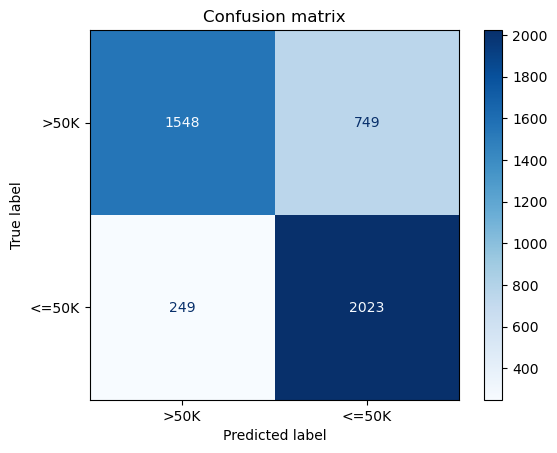

In [113]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_show = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['>50K', '<=50K'])
cm_show.plot(cmap='Blues')
plt.title('Confusion matrix')
plt.show()

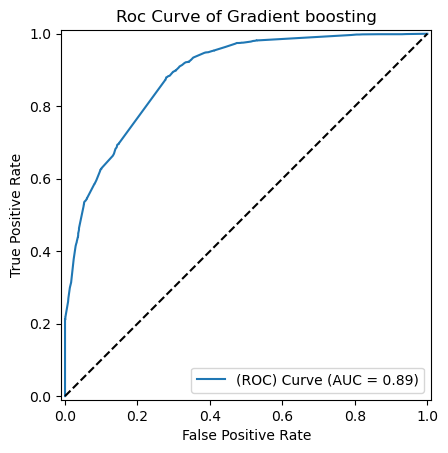

In [82]:
# Calculate True Positive Rate (TPR), False Positive Rate (FPR), and Thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='>50K')

roc_auc = auc(fpr, tpr)
# Calculate AUC Score:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='(ROC) Curve')

display.plot()
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Roc Curve of Gradient boosting')
plt.show()

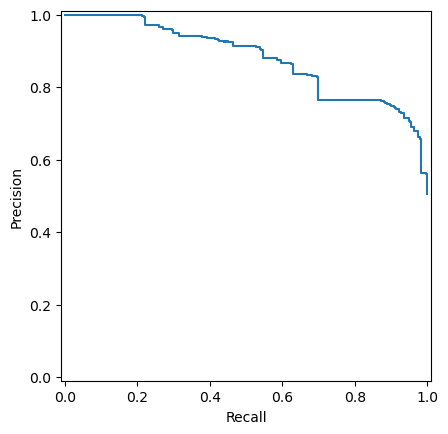

In [83]:

precision, recall, _ = precision_recall_curve(y_true=y_test, y_score=y_pred_prob,pos_label='>50K')
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [84]:
import pickle
file = open('model','wb')
pickle.dump(best_model,file)
file.close()